In [6]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.corpus import stopwords
import string
import os
import re
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('emails.txt') #read the CSV file

In [8]:
df.head(5)

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [9]:
df.shape

(5728, 2)

In [10]:
df.columns

Index(['text', 'spam'], dtype='object')

In [11]:
df.drop_duplicates(inplace = True)

In [12]:
df.shape

(5695, 2)

In [13]:
df.isnull().sum()

text    0
spam    0
dtype: int64

In [14]:
df.spam.value_counts(normalize=True)

0    0.759789
1    0.240211
Name: spam, dtype: float64

In [15]:
from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import SnowballStemmer

In [16]:
def clean_txt(sent):
    #Stripping white spaces before and after the text
    sent = sent.strip()
    #Replacing multiple spaces with a single space
    result = re.sub("\s+", " ", sent)
    #Replacing Non-Alpha-numeric and non space charecters with nothing
    result1 = re.sub("[^\w\s]","",result)
    tokens = word_tokenize(sent.lower())
    stop_updated = stopwords.words("english")  +  ["would", "could","told","subject"]
    text = [term for term in tokens if term not in stop_updated and len(term) > 2] 
    res = " ".join(text)
    return res

In [17]:
df['text'] = df.text.apply(clean_txt)

In [18]:
df.head()

,text,spam
0,naturally irresistible corporate identity real...,1
1,stock trading gunslinger fanny merrill muzo co...,1
2,unbelievable new homes made easy wanting show ...,1
3,color printing special request additional info...,1
4,money get software cds software compatibility ...,1


In [19]:
X = df.text.values
y = df.spam.values

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=3500)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [22]:
print(X_train_tfidf.shape,X_test_tfidf.shape)

(3986, 3500) (1709, 3500)


In [23]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [24]:
y_pred = classifier.predict(X_test_tfidf)

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve,auc

In [26]:
accuracy_score(y_test,y_pred)

0.981275599765945

In [27]:
confusion_matrix(y_test,y_pred)

array([[1263,    6],
       [  26,  414]], dtype=int64)

In [28]:
New_Email = pd.DataFrame([["undelivered email error"],["visiting bangalore, on leave"]], columns = ["text"])
New_Email

,text
0,undelivered email error
1,"visiting bangalore, on leave"


In [29]:
#Making predictions on new dataset

In [30]:
New_Email['clean_text'] = New_Email.text.apply(clean_txt)

In [31]:
New_Email.clean_text.values

array(['undelivered email error', 'visiting bangalore leave'],
      dtype=object)

In [32]:
newemail_tfidf = tfidf_vectorizer.transform(New_Email.clean_text.values)

In [33]:
classifier.predict(newemail_tfidf)

array([1, 0], dtype=int64)

In [34]:
f1_score(y_test,y_pred)

0.9627906976744187

In [35]:
def compute_auc(test, train_instance):
    probs = train_instance.predict_proba(test)
    prob_positive = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test,prob_positive)
    roc_auc = auc(fpr,tpr)
    return roc_auc,fpr,tpr,threshold

In [36]:
roc_auc, fpr, tpr,th = compute_auc(X_test_tfidf,classifier)
roc_auc

0.9977836879432624

In [37]:
def plot_ROC(roc,fpr,tpr):
    plt.title("receiver Operating Charecteristc")
    plt.plot(fpr,tpr,'red',label = 'AUC=%0.2f'% roc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1], color = 'darkblue',linestyle='--')
    plt.ylabel('True positive Rate')
    plt.xlabel('False positive Rate')
    plt.show()

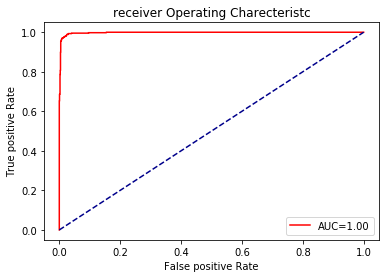

In [38]:
plot_ROC(roc_auc,fpr,tpr)

In [39]:
ftt = pd.DataFrame(np.hstack((th.reshape(-1,1),fpr.reshape(-1,1),tpr.reshape(-1,1))),columns = ['threshold','fpr','tpr'])
ftt.head(20)

,threshold,fpr,tpr
0,1.999981,0.000000,0.000000
1,0.999981,0.000000,0.002273
2,0.999303,0.000000,0.159091
3,0.999300,0.000000,0.163636
4,0.998913,0.000000,0.211364
5,0.998908,0.000000,0.215909
6,0.982199,0.000000,0.375000
7,0.981865,0.000000,0.379545
8,0.965220,0.000000,0.465909
9,0.965091,0.000000,0.475000


In this scenario :
- FP means an email which is actually not spam but  predicted as spam - Type-1 error
- FN means an email which is actually not a spam but not the model predicted it as spam - Type-2 error
since there exists a tradeoff between FN and FP, lets try to minimize FP's so that we avoid flagging of our important emails as spams


Hence from the ROC curve choose that threshold which results in small FP's

In [40]:
probs = classifier.predict_proba(X_test_tfidf)
prob_positive = probs[:,1]


In [41]:
#Predictions for various values of threshold
#0.993, 0.8858....

In [42]:
new_pred = (prob_positive>0.993).astype("int")
new_pred

array([0, 0, 0, ..., 0, 0, 1])

In [43]:
cm = confusion_matrix(y_test,new_pred)
cm

array([[1269,    0],
       [ 302,  138]], dtype=int64)

In [44]:
### SVM
from sklearn.svm import SVC
svc=SVC()
svc.fit(X_train,y_train)


ValueError: could not convert string to float: 'good morning john shall see christie tomorrow shall talk project friday feb works vince john martin 2000 vkamins enron com good morning vince update question first talked christie corresponded via mail dates talk lay skilling fastow yet christie working prompt next week second item business question want see move meeting spring business education new economy workshop back week friday february one attendees conference wants attend march let know asap works committments number folks workshop think great fun wonderful learning experience john john martin carr collins chair finance finance department baylor university box 98004 waco 76798 254 710 4473 office 254 710 1092 fax martin baylor edu web http hsb baylor edu html martinj home html'

In [ ]:
y_pred=svc.predict(X_test_tfidf)


In [ ]:
accuracy_score(y_test,y_pred)

In [ ]:
confusion_matrix(y_test,y_pred)

In [ ]:
f1_score(y_test,y_pred)